In [3]:
# ===============================
# 1. GEREKLİ KÜTÜPHANELER
# ===============================
import os
import shutil
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [4]:
# ===============================
# 2. VERİ SETİNİ TRAIN / VAL / TEST AYIRMA
# ===============================
base_dir = "realwaste-main/RealWaste"
output_dir = "realwaste_split"

os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, img_list in [("train", train_imgs), ("val", val_imgs), ("test", test_imgs)]:
        split_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(os.path.join(cls_path, img), os.path.join(split_dir, img))

print("Veri seti hazır")


Veri seti hazır


In [5]:
# ===============================
# 3. DATA AUGMENTATION (DERS DÜZEYİ)
# ===============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("realwaste_split/train", transform=transform_train)
val_dataset   = datasets.ImageFolder("realwaste_split/val", transform=transform_test)
test_dataset  = datasets.ImageFolder("realwaste_split/test", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)


In [6]:
# ===============================
# 4. MODEL (RESNET18 - TRANSFER LEARNING)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")

# Önceki katmanları dondur
for param in model.parameters():
    param.requires_grad = False

# Son katmanı değiştir
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


In [7]:
# ===============================
# 5. MODEL EĞİTİMİ
# ===============================
epochs = 10

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Accuracy: {train_acc:.2f}%")


Epoch [1/10] - Loss: 157.4096 - Accuracy: 48.93%
Epoch [2/10] - Loss: 106.2425 - Accuracy: 67.23%
Epoch [3/10] - Loss: 93.0866 - Accuracy: 70.06%
Epoch [4/10] - Loss: 82.9070 - Accuracy: 73.46%
Epoch [5/10] - Loss: 79.5112 - Accuracy: 74.15%
Epoch [6/10] - Loss: 75.6458 - Accuracy: 75.17%
Epoch [7/10] - Loss: 73.0600 - Accuracy: 75.93%
Epoch [8/10] - Loss: 69.9828 - Accuracy: 76.44%
Epoch [9/10] - Loss: 68.1939 - Accuracy: 77.40%
Epoch [10/10] - Loss: 67.0923 - Accuracy: 78.27%


In [8]:
# ===============================
# 6. TEST + METRİKLER
# ===============================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.69      0.71      0.70        70
      Food Organics       0.79      0.89      0.83        62
              Glass       0.85      0.70      0.77        63
              Metal       0.66      0.82      0.73       119
Miscellaneous Trash       0.70      0.40      0.51        75
              Paper       0.89      0.63      0.73        75
            Plastic       0.68      0.79      0.73       139
      Textile Trash       0.79      0.69      0.73        48
         Vegetation       0.85      0.97      0.91        66

           accuracy                           0.74       717
          macro avg       0.77      0.73      0.74       717
       weighted avg       0.75      0.74      0.73       717



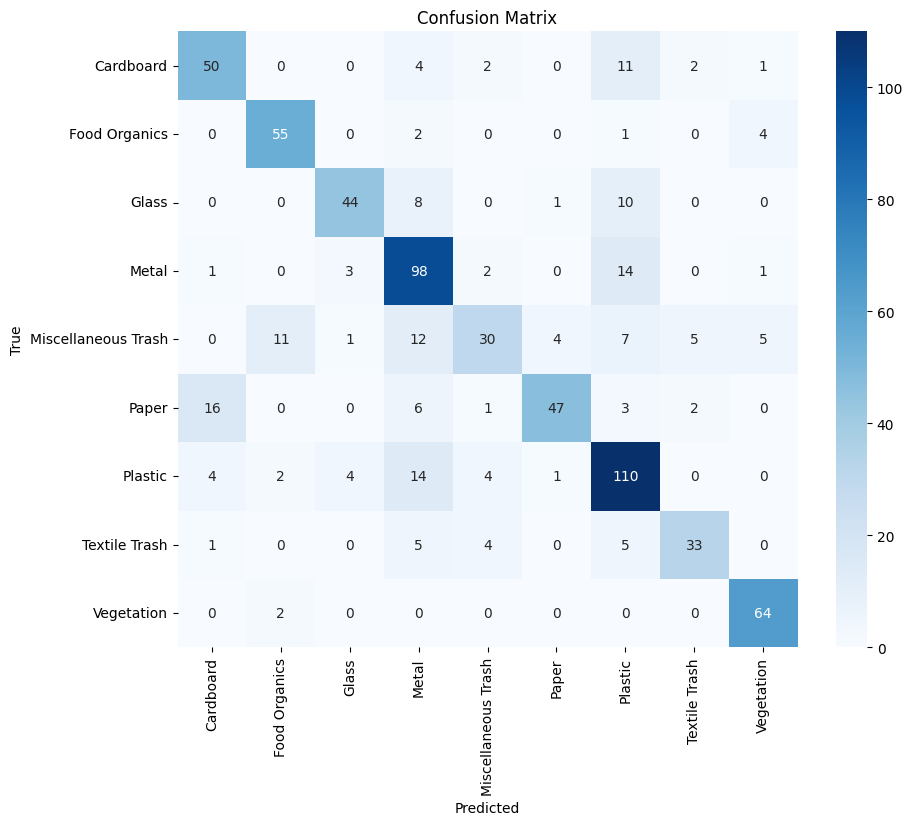

In [9]:
# ===============================
# 7. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [10]:
torch.save(model.state_dict(), "realwaste_resnet18.pth")
print("Model başarıyla kaydedildi ✅")


Model başarıyla kaydedildi ✅


In [11]:
!pip install gradio


In [ ]:
# Gradio Arayüzü
import gradio as gr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

# MODEL TANIMI
def get_model(num_classes):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# MODEL YÜKLEME
MODEL_PATH = "realwaste_resnet18.pth"

CLASS_NAMES = [
    "Cardboard", "Food Organics", "Glass",
    "Metal", "Miscellaneous Trash", "Paper",
    "Plastic", "Textile Trash", "Vegetation"
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes=len(CLASS_NAMES))
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

# TRANSFORM
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# TAHMİN FONKSİYONU
def predict(image):
    if image is None:
        return "Lütfen bir görüntü yükleyin.", {}

    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)

    img_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_idx = torch.argmax(probs).item()

    confidence_dict = {CLASS_NAMES[i]: float(probs[i]) for i in range(len(CLASS_NAMES))}
    result_text = f"Tahmin: {CLASS_NAMES[pred_idx]}\nGüven: %{probs[pred_idx] * 100:.1f}"

    return result_text, confidence_dict

# ÖRNEK GÖRSELLER
example_images = [
    "demo_images/cardboard.jpeg",
    "demo_images/organic.jpeg",
    "demo_images/plastic.jpeg"
]

# GRADIO ARAYÜZ
with gr.Blocks() as demo:
    gr.Markdown("# 🗑️ Atık Sınıflandırma Sistemi")
    gr.Markdown("ResNet18 modeli kullanılarak atık türü tahmini yapılır.")

    with gr.Row():
        with gr.Column():
            image_input = gr.Image(label="Görüntü Yükleyin", type="pil", height=300)
            predict_btn = gr.Button("Tahmin Et")
            gr.Examples(examples=example_images, inputs=image_input, label="Örnek Görseller")

        with gr.Column():
            output_text = gr.Textbox(label="Sonuç", lines=3)
            output_chart = gr.Label(label="Olasılık Dağılımı", num_top_classes=len(CLASS_NAMES))

    predict_btn.click(fn=predict, inputs=image_input, outputs=[output_text, output_chart])

# ÇALIŞTIR
demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://08ebd92456e555f89a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
